# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128 -q

In [ ]:
#!pip install numpy==1.21.0 transformers==4.12.5 imblearn lightgbm wordcloud==1.8.2.2 Pillow==9.5.0 -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import transformers
from wordcloud import WordCloud
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier

RANDOM_STATE = 42

In [4]:
try:
    df = pd.read_csv('toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [7]:
df.shape

(159292, 2)

Датасет содержит 159292 записи с коментариями и метками токсичности. Пропусков в данных нет.

Рассмотрим подробнее столбец *toxic*.

C:\Users\Mikhail\.conda\envs\da_practicum_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


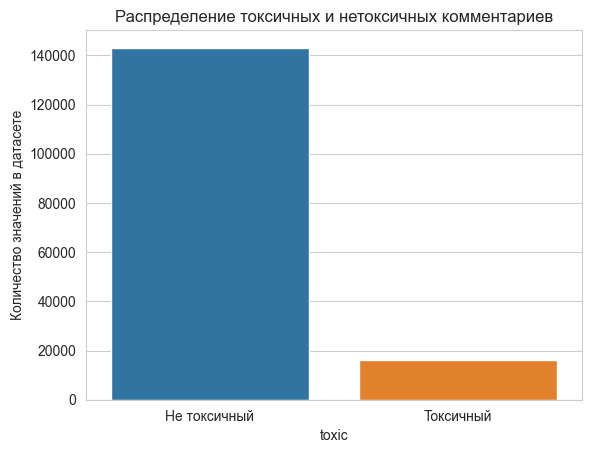

In [8]:
sns.set_style('whitegrid')
sns.countplot(df['toxic'].replace({0: 'Не токсичный', 1: 'Токсичный'}))
plt.title('Распределение токсичных и нетоксичных комментариев')
plt.ylabel('Количество значений в датасете');

Видим значительный дизбаланс классов, что будем учитывать при обучении моделей.

Используем облако слов, чтобы получить общее представление о тематике и о наиболее часто встречаемых словах в токсичных и нетоксичных коментариях.

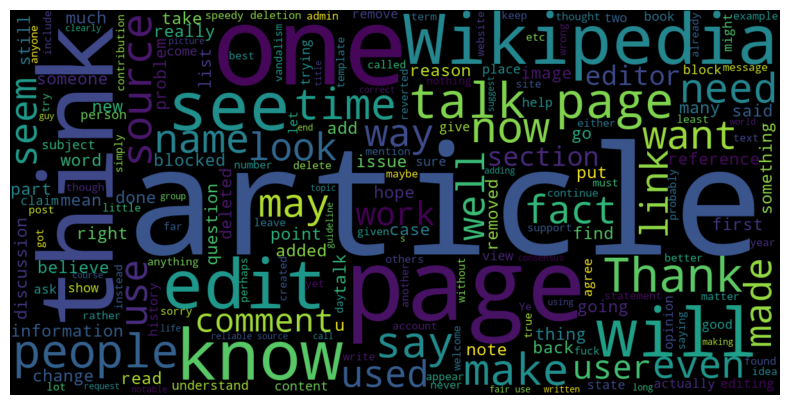

In [9]:
all_text = ' '.join(df['text'].astype(str))
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='black',
    max_words=200,
    colormap='viridis'
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Ограничим наши данные 5000 экземплярами для более быстрой работы. Важно сохранить распределение классов в подвыборке.

In [10]:
_, df = train_test_split(
    df,
    test_size=5000,
    stratify=df['toxic'],
    random_state=RANDOM_STATE
)

Для обучения токенизируем текста в векторы с одинаковой длинной. В нашем случае векторы будут иметь длину 512. Используем модель toxic-bert предобученную определять токсичные тексты.

In [11]:
model_name = 'unitary/toxic-bert'
model = transformers.AutoModel.from_pretrained(model_name)
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))
 
padded = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Создадим эмбеддинги для обучения моделей. Для увеличения скорости вычислений используем GPU.

In [12]:
%%time

batch_size = 100
embeddings = []

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch.to(device), attention_mask=attention_mask_batch.to(device))
        
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

Wall time: 1min 28s


## Обучение

Сформируем тренировочную и тестовую выборки в пропорции 80-20 для обучения и тестирования лучшей модели.

In [13]:
features = np.concatenate(embeddings)
target = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=.2, 
    stratify=target, 
    random_state=RANDOM_STATE
) 

In [14]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)), #SMOTE позволит увеличить количество примеров миноритарного класса, избегая при этом переобучения
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [15]:
param_grid = [
    
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
    },
    
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
    },
    
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)], 
    }
]

In [16]:
gs = GridSearchCV(
    pipeline, 
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
gs.fit(X_train, y_train)

C:\Users\Mikhail\.conda\envs\da_practicum_env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\Mikhail\.conda\envs\da_practicum_env\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Не удается найти указанный файл
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Mikhail\.conda\envs\da_practicum_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\Mikhail\.conda\envs\da_practicum_env\lib\subprocess.py", line 505, in run


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('models',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression(random_state=42)]},
                         {'models': [RandomForestClassifier(random_state=42)]},
                         {'models': [LGBMClassifier(random_state=42)]}],
             scoring='f1')

In [17]:
print('Лучшая модель и её параметры:\n\n', gs.best_estimator_)
print ('\nF1 метрика лучшей модели при кросс-валидации:', round(gs.best_score_, 3))

Лучшая модель и её параметры:

 Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('models', RandomForestClassifier(random_state=42))])

F1 метрика лучшей модели при кросс-валидации: 0.934


In [18]:
y_pred = gs.predict(X_test)
print(f"Результат лучшей модели на тестовых данных: {f1_score(y_test, y_pred):.3f}")

Результат лучшей модели на тестовых данных: 0.943


## Выводы

С помощью полученных от заказчика данных был разработан инструмент для определения токсичных комментариев. 

Для это была использована языковая модель toxic_Bert из открытого доступа. С помощью данной модели были получены CLS-токены комменариев. 

В проекте были обучены три модели на кросс-валидации:
- Логистическая регрессия
- Случайный лес
- LightGBM

Лучший результат при кросс-валидации показала модель **RandomForestClassifier** (F1 метрика равна **0,934**), на тестовых данных ее результат **0,943**.

Таким образом, была построена модель со значением метрики качества F1 более 0.75 для интернет-магазина «Викишоп».